In [71]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [72]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils

from scipy import signal 

In [73]:
%matplotlib notebook

In [74]:
%sql sqlite:///schema/test.db

u'Connected: None@schema/test.db'

In [75]:
# Create Butterworth filter
def apply_butter(freq_1, freq_2, fs, sig):
    """ Apply second order Butterworth filter to sig
    fs is sampling rate
    """
    sos = sp.signal.butter(
        2, (np.array([freq_1, freq_2]) / (fs / 2)), btype='bandpass', analog=False, output='sos'
    )
    sig = signal.sosfiltfilt(sos, sig)
    return sig

def normalize(sig):
    """ Normalize range and zero-mean the signal
    """
    sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))
    return sig - np.mean(sig)

In [76]:
# Load test data (RCH90b)
cur_experiment_id = 1
result = %sql select data from mic where experiment_id = :cur_experiment_id

mic_1 = np.array(result[0][0])
mic_2 = np.array(result[2][0])

# Median filter the data
mic_1 = signal.medfilt(mic_1, 21)
mic_2 = signal.medfilt(mic_2, 21)

# Zero-mean
mic_1 = mic_1 - np.mean(mic_1)
mic_2 = mic_2 - np.mean(mic_2)

# Butterworth (and normalize and zero-mean)
f1 = 250
f2 = 350
fs = 9.6e6
mic_1_butter = apply_butter(f1, f2, fs, mic_1)
mic_1_butter = normalize(mic_1_butter)

mic_2_butter = apply_butter(f1, f2, fs, mic_2)
mic_2_butter = normalize(mic_2_butter)

Done.


<IPython.core.display.Javascript object>


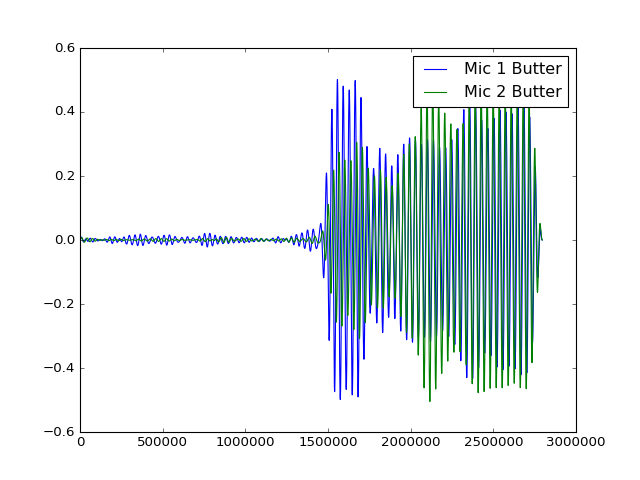

In [77]:
plt.figure(1)
plt.plot(mic_1_butter, label='Mic 1 Butter', lw=1)
plt.plot(mic_2_butter, label='Mic 2 Butter', lw=1)
plt.legend()
plt.show()

[1490548 1523431 1556915 1591945 1628403]
[1501260 1533943 1566984 1601388 1638238]


<IPython.core.display.Javascript object>


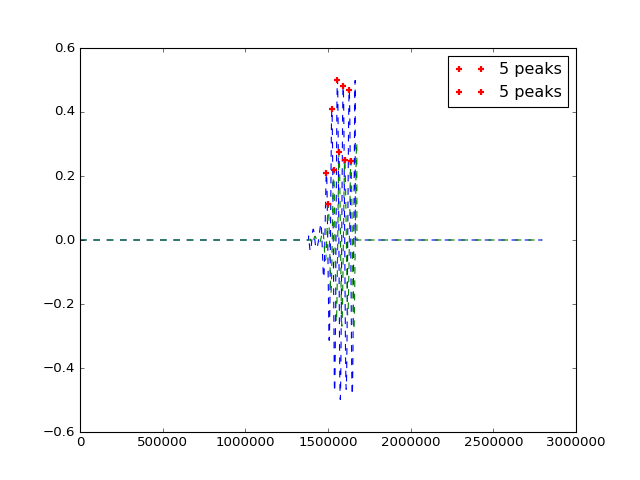

In [78]:
from peakutils.plot import plot as pplot

def get_n_peaks(sig, thres, min_dist, n):
    """ Gets the first n peaks > thres ([0, 1]) and greater than min_dist apart
    """
    idx = peakutils.peak.indexes(sig, thres=thres, min_dist=min_dist)
    return idx[:n]

idx_1 = get_n_peaks(mic_1_butter, 0.6, 1000, 5)
idx_2 = get_n_peaks(mic_2_butter, 0.6, 1000, 5)

print idx_1
print idx_2

sig1 = mic_1_butter
sig2 = mic_2_butter

# Window (Window around first 10 peaks)
sig1[:(idx_1[0]-3*36000)] = 0
sig1[idx_1[-1]+36000:] = 0

sig2[:(idx_2[0]-3*36000)] = 0
sig2[idx_2[-1]+36000:] = 0

plt.figure(2)
pplot(np.arange(len(sig1)), sig1, idx_1)
pplot(np.arange(len(sig2)), sig2, idx_2)

plt.show()

In [79]:
# Window original signals
mic_1_crop = np.array(mic_1)
mic_2_crop = np.array(mic_2)

# Window (Window around first 10 peaks)
mic_1_crop[:(idx_1[0]-3*36000)] = 0
mic_1_crop[idx_1[-1]+36000:] = 0

mic_2_crop[:(idx_2[0]-3*36000)] = 0
mic_2_crop[idx_2[-1]+36000:] = 0


In [80]:
# Compute xcorr (using previous code)

import locate

[max_corr, delay] = locate.xcorr(mic_1_crop, mic_2_crop)
print max_corr, delay

55810373.3777 9929


<IPython.core.display.Javascript object>


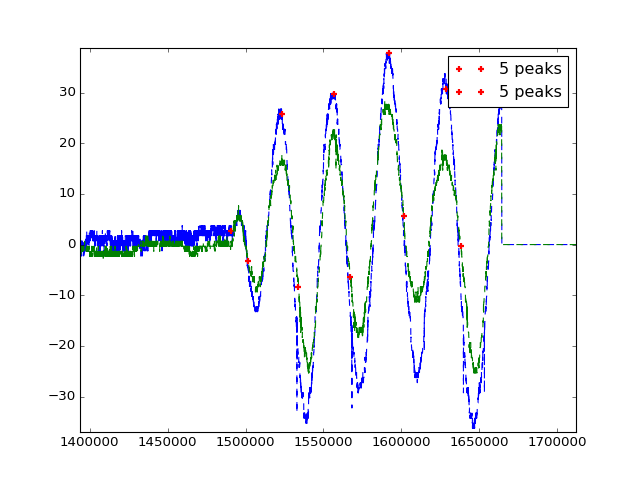

In [81]:
# Plot out optimal xcorr
# NB: np.roll is circular shift, since this is cropped this is fine here.

plt.figure(3)
pplot(np.arange(len(mic_1_crop)), mic_1_crop, idx_1)
pplot(np.arange(len(mic_2_crop)), np.roll(mic_2_crop, -delay), idx_2)

<IPython.core.display.Javascript object>


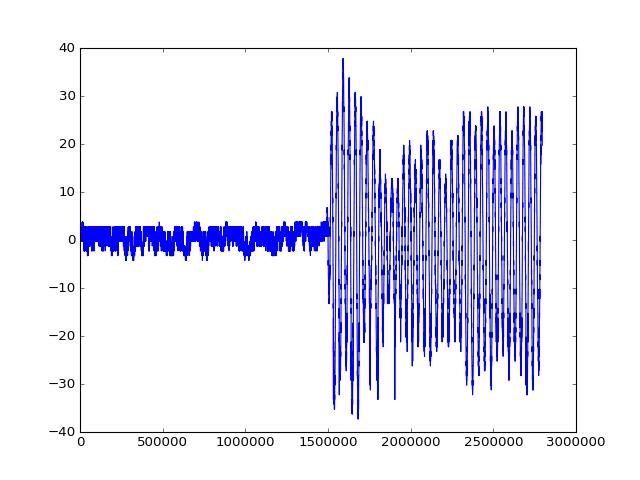

8388608 23.0
4184108


<IPython.core.display.Javascript object>


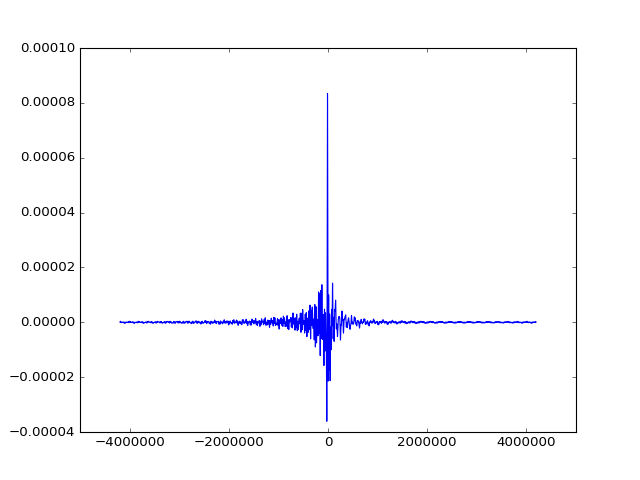

Delay: 10196


In [82]:
def next_pow_2(n):
    """ Much faster to fft at next pow of 2
    """
    return np.power(2, np.ceil(np.log2(n)))

def gcc_xcorr(sig1, sig2, fmin, fmax, fs):
    """ GCC-PHAT windowed on [fmin, fmax]
    """
    Nfft = int(next_pow_2(len(sig1) + len(sig2) - 1))
    print Nfft, np.log2(Nfft)
    
    SIG1 = np.fft.fftshift(np.fft.fft(sig1, n=Nfft))
    SIG2 = np.fft.fftshift(np.fft.fft(sig2, n=Nfft))
    freq = np.fft.fftshift(np.fft.fftfreq(n=Nfft, d=1./fs))
    
    CORR = np.multiply(SIG1, np.conj(SIG2))
    CORR[np.where(np.abs(freq) < fmin)] = 0 # window in frequency domain
    CORR[np.where(np.abs(freq) > fmax)] = 0
        
    CORR = CORR / (np.abs(SIG1) * np.abs(np.conj(SIG2)))
    corr = np.fft.ifft(np.fft.ifftshift(CORR))
    corr = np.fft.fftshift(corr)
    
    ind = np.argmax(corr)
    return corr, ind

mic_1_trunc = mic_1_crop[(idx_1[0]-3*36000):idx_1[-1]+36000]
mic_2_trunc = mic_2_crop[(idx_2[0]-3*36000):idx_2[-1]+36000]

"""
MIC_1 = np.fft.fftshift(np.fft.fft(mic_1_trunc))
freq = np.fft.fftshift(np.fft.fftfreq(len(MIC_1), d=1./fs))

plt.figure(4)
plt.plot(mic_1_trunc)
plt.show()

plt.figure(5)
plt.plot(freq[np.where(np.abs(freq) < 500)], np.abs(MIC_1[np.where(np.abs(freq) < 500)]))
plt.show()
"""

plt.figure(4)
plt.plot(mic_1)
plt.show()

# Try gcc xcorr on raw signals 
corr, ind = gcc_xcorr(mic_1_crop, mic_2_crop, 50, 500, fs)
print ind
samples = np.arange(len(corr)) - len(corr)/2
delay = -samples[ind]

plt.figure(6)
plt.plot(samples, corr)
plt.show()

print 'Delay: %d' % delay

# NB: GCC-PHAT on truncated signals will require shifting... to account for shift in truncation
# Right now just use cropped signal

<IPython.core.display.Javascript object>


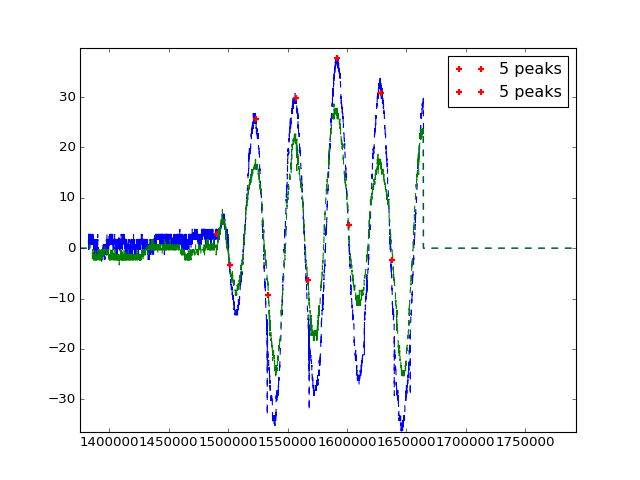

In [83]:
plt.figure(7)
pplot(np.arange(len(mic_1_crop)), mic_1_crop, idx_1)
pplot(np.arange(len(mic_2_crop)), np.roll(mic_2_crop, -delay), idx_2)